# Plot Compound Years for CESM

You need to run cesmIndeces.ipnyb first

In [2]:
#import my functions
import sys
sys.path.append('../')

#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.overlapBins as overlapBins

In [3]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas
import scipy.stats

%matplotlib inline

In [4]:
#The data
firePos=xarray.open_dataset('results/cesmFirePos.nc').sel(experiment=_model.cesmNoRepeats)
fireNeg=xarray.open_dataset('results/cesmFireNeg.nc').sel(experiment=_model.cesmNoRepeats)

# In non-overlapping 30 year bins

Calculate non-overlapping 30 year bins, and sum the number of events in them

In [5]:
firePos

<xarray.Dataset>
Dimensions:      (experiment: 13, year: 1250)
Coordinates:
  * year         (year) int64 850 851 852 853 854 ... 2095 2096 2097 2098 2099
  * experiment   (experiment) object 'LME.002' 'LME.003' ... '012' '013'
Data variables:
    nino34       (experiment, year) float64 ...
    dmi          (experiment, year) float64 ...
    sam          (experiment, year) float64 ...
    nEvents      (experiment, year) float64 ...
    all3         (experiment, year) float64 ...
    nino34+dmi   (experiment, year) float64 ...
    nino34+sam   (experiment, year) float64 ...
    dmi+sam      (experiment, year) float64 ...
    anyCompound  (experiment, year) float64 ...
Attributes:
    all3:     ['nino34', 'dmi', 'sam']
    indeces:  ['nino34', 'dmi', 'sam']
    pairs:    ['nino34+dmi', 'nino34+sam', 'dmi+sam']

In [6]:
yearBins=numpy.arange(860, 2100, 30)

binMid=numpy.arange(875, 2086, 30)

#binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid).sum() #This line is a bit problematic. If you have all nans in the bin, it will give you a sum of 0. It is probably more useful to return a nan

#Do the sum for each interval, but only it there are no Nans.
binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid).map(
    lambda ds : ds.sum(dim='year').where(ds.isnull().any(dim='year')!=True)
)
binnedFirePos=binnedFirePos.rename({'year_bins':'year'})

binnedFirePos=binnedFirePos.assign_attrs({
        **firePos.attrs,
        'Bins':'Non-Overlapping 30 year bins, seperating by 10 year intervals', 
        'Year':'Midpoint of bin'
    })

In [7]:
#check that years with no data are nan
binnedFirePos.sel(experiment='001')

<xarray.Dataset>
Dimensions:      (year: 41)
Coordinates:
  * year         (year) int64 875 905 935 965 995 ... 1955 1985 2015 2045 2075
    experiment   <U3 '001'
Data variables:
    nino34       (year) float64 0.0 2.0 0.0 0.0 0.0 0.0 ... 0.0 3.0 nan nan nan
    dmi          (year) float64 0.0 1.0 2.0 1.0 3.0 1.0 ... 2.0 3.0 nan nan nan
    sam          (year) float64 3.0 4.0 3.0 5.0 5.0 4.0 ... 3.0 2.0 nan nan nan
    nEvents      (year) float64 12.0 24.0 20.0 20.0 18.0 ... 12.0 nan nan nan
    all3         (year) float64 1.0 1.0 1.0 2.0 2.0 2.0 ... 0.0 0.0 nan nan nan
    nino34+dmi   (year) float64 2.0 2.0 2.0 3.0 0.0 1.0 ... 3.0 2.0 nan nan nan
    nino34+sam   (year) float64 0.0 2.0 2.0 0.0 2.0 0.0 ... 1.0 0.0 nan nan nan
    dmi+sam      (year) float64 1.0 3.0 2.0 1.0 0.0 2.0 ... 1.0 0.0 nan nan nan
    anyCompound  (year) float64 4.0 8.0 7.0 6.0 4.0 5.0 ... 5.0 2.0 nan nan nan
Attributes:
    all3:     ['nino34', 'dmi', 'sam']
    indeces:  ['nino34', 'dmi', 'sam']
    pairs:    ['nino34+dmi', 'nino34+sam', 'dmi+sam']
    Bins:     Non-Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

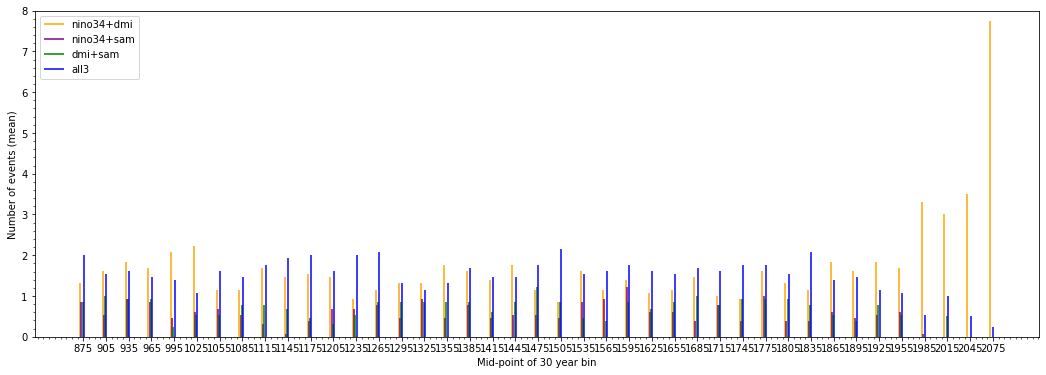

In [8]:
overlapBins.binPlot(binnedFirePos.sel(experiment=_model.cesmNoRepeats))

Group into three time periods: pre 1850, 1850-2005 and 2005 to 2100

In [9]:
groupA = binnedFirePos.sel(experiment=_model.cesmNoRepeats, year=slice(850,1850))
groupB = binnedFirePos.sel(experiment=_model.cesmNoRepeats, year=slice(1850,2006))
groupC = binnedFirePos.sel(experiment=_model.cesmRcp85, year=slice(2006,2100))

In [10]:
groupC.nino34.values.flatten()

array([0., 1., 1., 1., 3., 2., 1., 3., 0., 2., 0., 2.])

In [11]:
toPlot=[ #*firePos.attrs['indeces'],
        *firePos.attrs['pairs'],'all3']

In [12]:
for iInd in toPlot:
    print(iInd)
    print(
        scipy.stats.f_oneway(
        groupA[iInd].values.flatten() , 
        groupB[iInd].values.flatten(), 
        groupC[iInd].values.flatten()
        )
    )

nino34+dmi
F_onewayResult(statistic=55.16097178313521, pvalue=2.1912386251156325e-22)
nino34+sam
F_onewayResult(statistic=5.364711238204568, pvalue=0.004950359168891299)
dmi+sam
F_onewayResult(statistic=7.0611071277087, pvalue=0.0009454963576984352)
all3
F_onewayResult(statistic=11.58508225234114, pvalue=1.2053252813308302e-05)


In [13]:
for iInd in toPlot:
    print(iInd)
    print(
        scipy.stats.ttest_ind(groupA[iInd].values.flatten() , 
        groupB[iInd].values.flatten())
    )
    

nino34+dmi
Ttest_indResult(statistic=-4.4526780215668795, pvalue=1.0503432709625514e-05)
nino34+sam
Ttest_indResult(statistic=1.6404297310381832, pvalue=0.10155497189791542)
dmi+sam
Ttest_indResult(statistic=2.90410928047, pvalue=0.0038486082556662368)
all3
Ttest_indResult(statistic=3.6173225295063376, pvalue=0.0003284142289977348)


In [14]:
for iInd in toPlot:
    print(iInd)
    print(
        scipy.stats.ttest_ind(groupA[iInd].values.flatten() , 
        groupC[iInd].values.flatten())
    )
    

nino34+dmi
Ttest_indResult(statistic=-10.092817522133252, pvalue=1.1137976730504202e-21)
nino34+sam
Ttest_indResult(statistic=2.8591658544808918, pvalue=0.004449931077304754)
dmi+sam
Ttest_indResult(statistic=2.501454531494464, pvalue=0.012731540907936803)
all3
Ttest_indResult(statistic=3.359293470662223, pvalue=0.0008496129026643314)


In [15]:
def mySlowFunction(input):
    y=input[0]
    if y<1850:
        result='A'
    elif y<2006:
        result='B'
    else:
        result='C'
        
    return result

<AxesSubplot:title={'center':'nino34'}, xlabel='[<function mySlowFunction at 0x7f9a010810d0>]'>

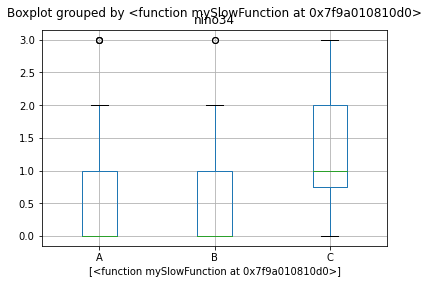

In [16]:
binnedFirePos.sel(experiment=_model.cesmNoRepeats).nino34.to_dataframe().boxplot(by=mySlowFunction)


# In overlapping 30 year bins

In [17]:
overBinFirePos = overlapBins.binSum(firePos)
overBinFireNeg = overlapBins.binSum(fireNeg)

Fire Promoting


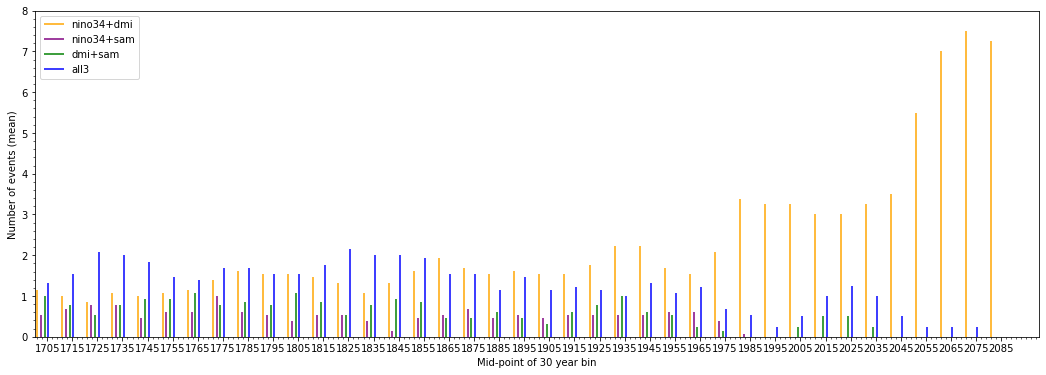

Not Fire Promoting


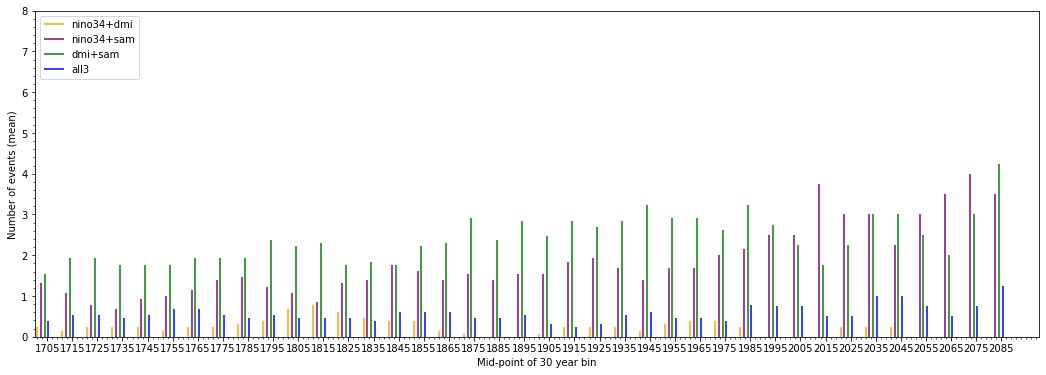

In [18]:
print("Fire Promoting")
overlapBins.binPlot(overBinFirePos.sel(experiment=_model.cesmNoRepeats))
plt.xlim(1700,2100)
plt.show()


print("Not Fire Promoting")
overlapBins.binPlot(overBinFireNeg.sel(experiment=_model.cesmNoRepeats))
plt.xlim(1700,2100)
plt.show()

# Time of emergence?

Function to calcuate 95% CI from pre-1850 results, and plot against all data.

    Confidence Interval	Z

    90%	1.645

    95%	1.960

In [52]:
def emergePlot(binnedXr, climatXr):

    # plot indeces for multi-experiment mean, and add some lines for CI
    
    # multi-experiment mean state (by index and time)
    meanXr=climatXr.mean()
    
    dims=list(climatXr.coords)
    dims.remove('year') #this is normall experiment (for CESM) or model (for CMIP)
    
    stdXr=climatXr.mean('year').std(dims)

    #Z-score for a 95% CI
    #Z = 1.645
    Z=1.96

    #these are the variable/index names to plot
    indexToPlot = list(binnedXr.data_vars)
    nIndices=len(indexToPlot)

    # define somewhere to plot
    fig = plt.figure(figsize=(18,3*nIndices))

    # for each variable number
    for i in range(nIndices):

        #create a subplot (row, column, size)
        fig.add_subplot(nIndices,1,i+1)

        # plot the actual data
        plotData=binnedXr[indexToPlot[i]]

        #blue line for multi-experiment mean, and light blue shading between min and max
        plt.plot(plotData.year, 
                 plotData.mean(dims).values, 
                 label=indexToPlot[i])
        plt.fill_between(plotData.year, 
                         plotData.min(dims).values, plotData.max(dims).values, 
                         color='lightblue')

        #An alternative would be to use shading with a CI, but this is a bit non-sensical becuase it crosses 0
        #cI=Z*plotData.std(dim='experiment')
        #plt.fill_between(plotData.year, 
        #                 (plotData.mean(dim='experiment')-cI).values, (plotData.mean(dim='experiment')+cI).values, 
        #                 color='lightblue')

        # draw some horizontal lines for criteria
        plt.axhline(y=meanXr[indexToPlot[i]]+Z*stdXr[indexToPlot[i]], dashes=(5,5), color='black')
        plt.axhline(y=meanXr[indexToPlot[i]]-Z*stdXr[indexToPlot[i]], dashes=(5,5), color='black')

        plt.axvline(x=1995)
        
        #Tidy up a bit
        plt.xlabel('year')
        plt.ylabel('number of events/30 years')
        #plt.xlim(1000,2100)
        #plt.ylim(0,10)
        plt.minorticks_on()
        plt.legend()


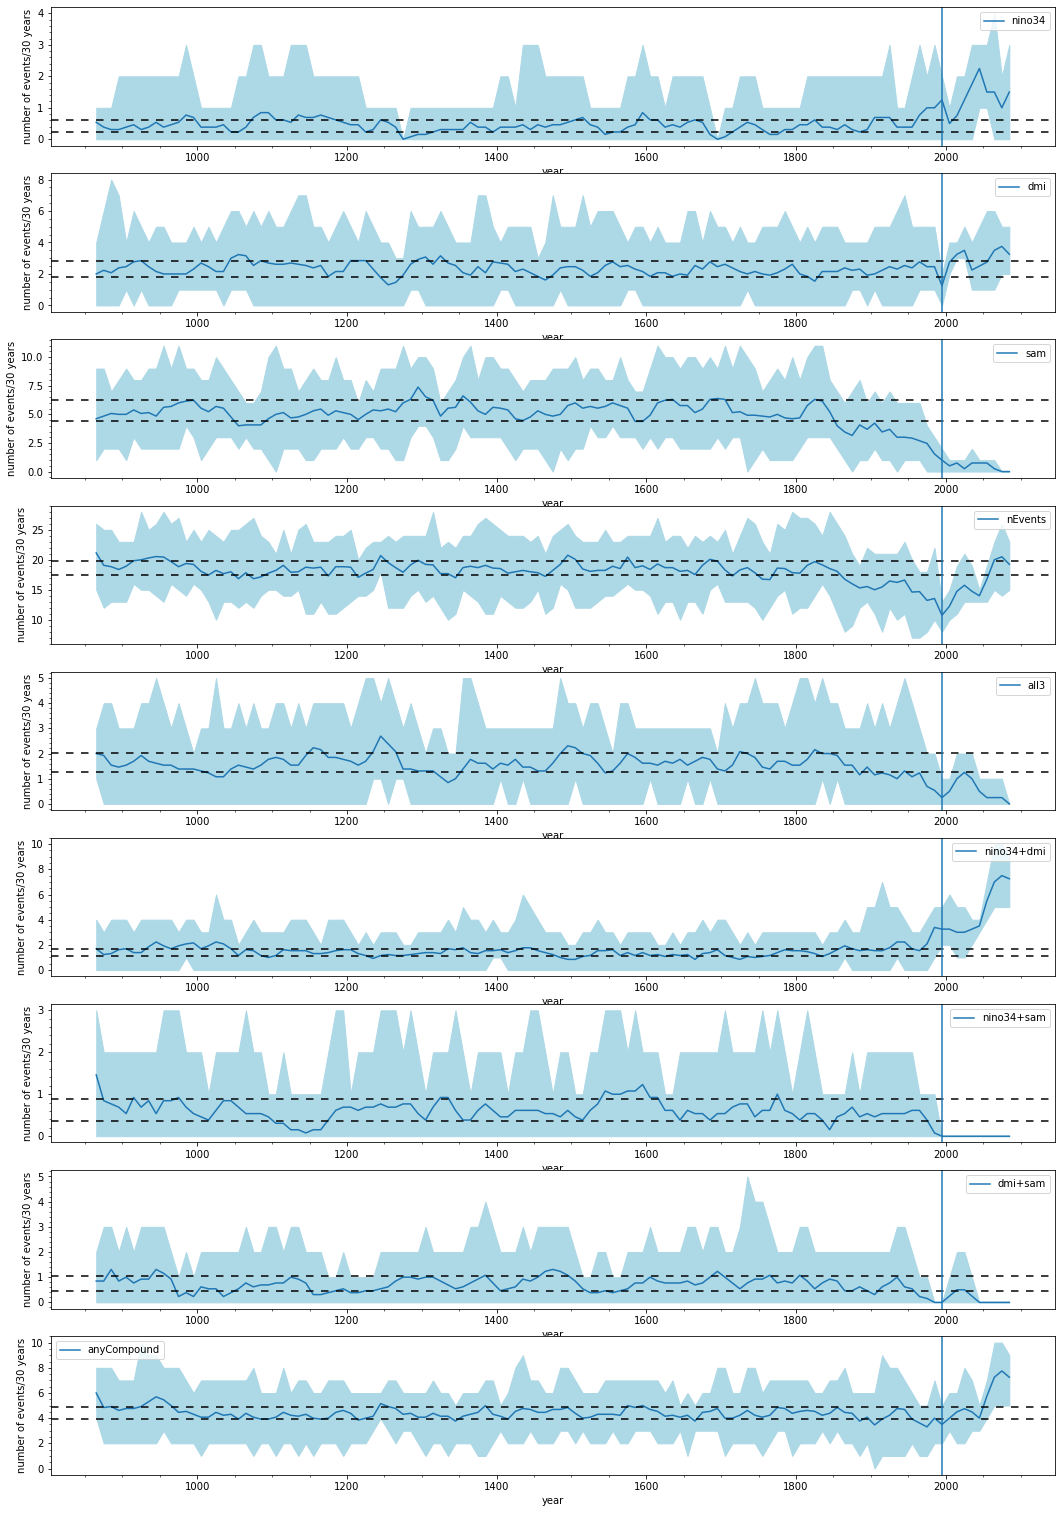

In [53]:
emergePlot(overBinFirePos.sel(experiment=_model.cesmNoRepeats), 
           overBinFirePos.sel(experiment=_model.cesmNoRepeats).where(overBinFirePos.year<1850))

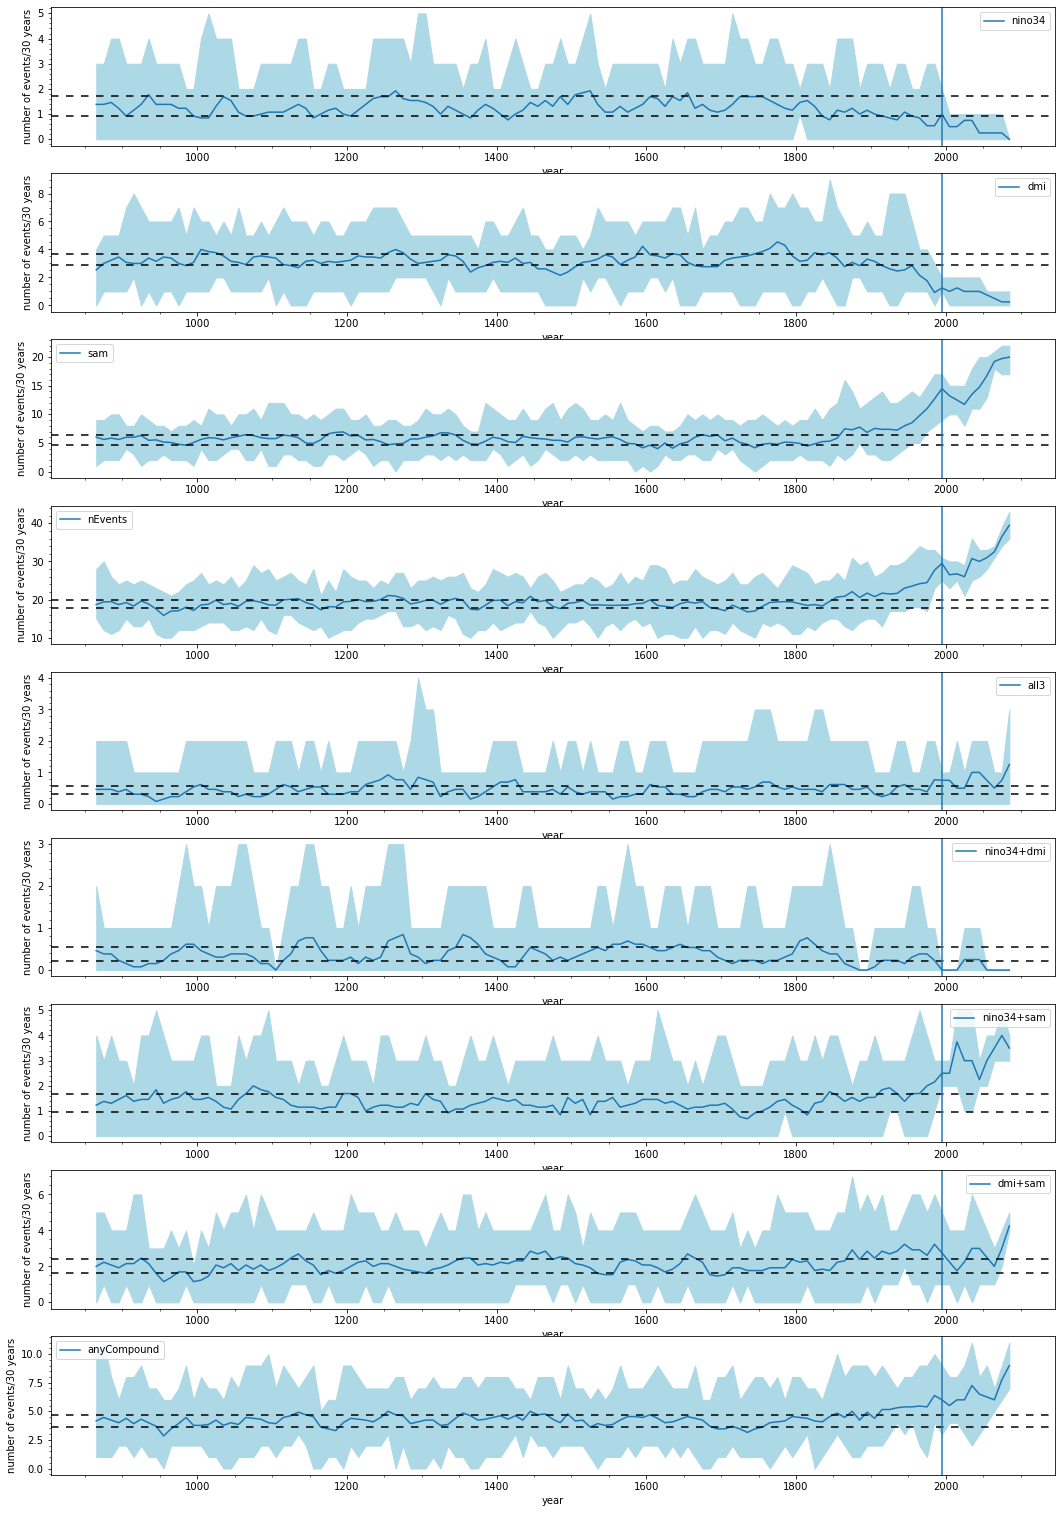

In [54]:
emergePlot(overBinFireNeg.sel(experiment=_model.cesmNoRepeats), 
          overBinFireNeg.sel(experiment=_model.cesmNoRepeats).where(overBinFireNeg.year<1850))

# emergence plot using east IO

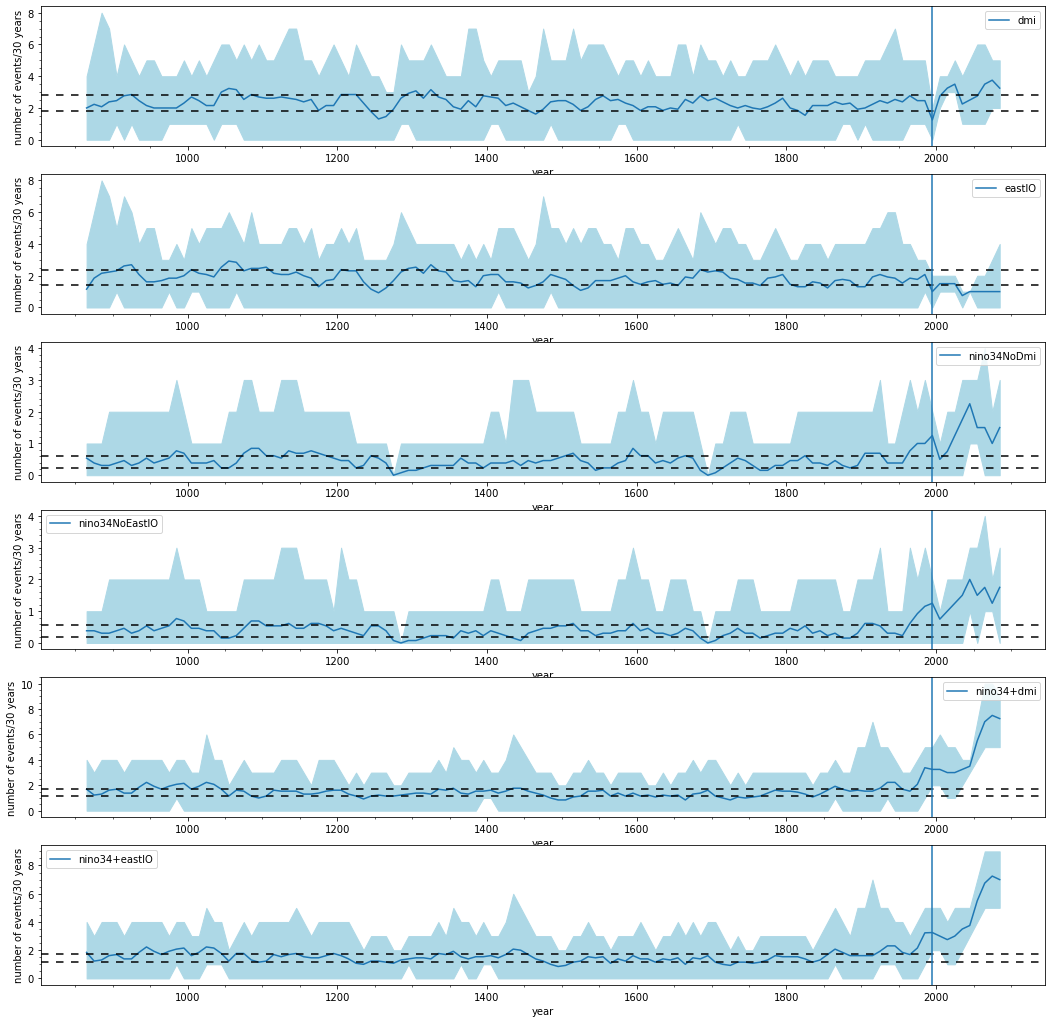

In [70]:
overBinEFirePos=overlapBins.binSum(
    xarray.open_dataset('results/cesmEFirePos.nc').sel(experiment=_model.cesmNoRepeats)
)

overBinComparison = xarray.merge([
    overBinFirePos.dmi,
    overBinEFirePos.eastIO,
    overBinFirePos.nino34.rename('nino34NoDmi'),
    overBinEFirePos.nino34.rename('nino34NoEastIO'),
    overBinFirePos['nino34+dmi'],
    overBinEFirePos['nino34+eastIO']
])

emergePlot(
    overBinComparison, overBinComparison.where(overBinEFirePos.year<1850)
        )


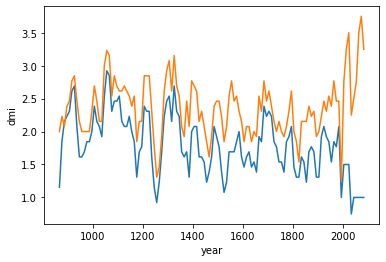

In [56]:
plt.figure()

overBinEFirePos.sel(experiment=_model.cesmNoRepeats).eastIO.mean('experiment').plot()
overBinFirePos.sel(experiment=_model.cesmNoRepeats).dmi.mean('experiment').plot()

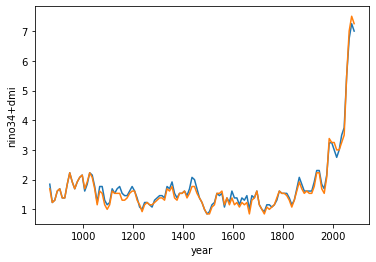

In [58]:
plt.figure()

overBinEFirePos['nino34+eastIO'].sel(experiment=_model.cesmNoRepeats).mean('experiment').plot()
overBinFirePos['nino34+dmi'].sel(experiment=_model.cesmNoRepeats).mean('experiment').plot()

In [60]:
overBinEFireNeg=overlapBins.binSum(
    xarray.open_dataset('results/cesmEFireNeg.nc').sel(experiment=_model.cesmNoRepeats)
)

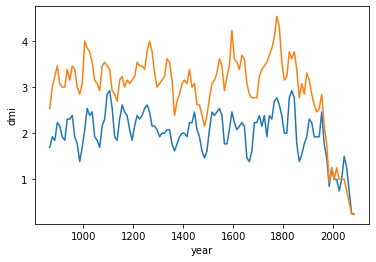

In [61]:
plt.figure()

overBinEFireNeg.sel(experiment=_model.cesmNoRepeats).eastIO.mean('experiment').plot()
overBinFireNeg.sel(experiment=_model.cesmNoRepeats).dmi.mean('experiment').plot()